ValueError: num must be an integer with 1 <= num <= 12, not (3, 6, 9, 12)

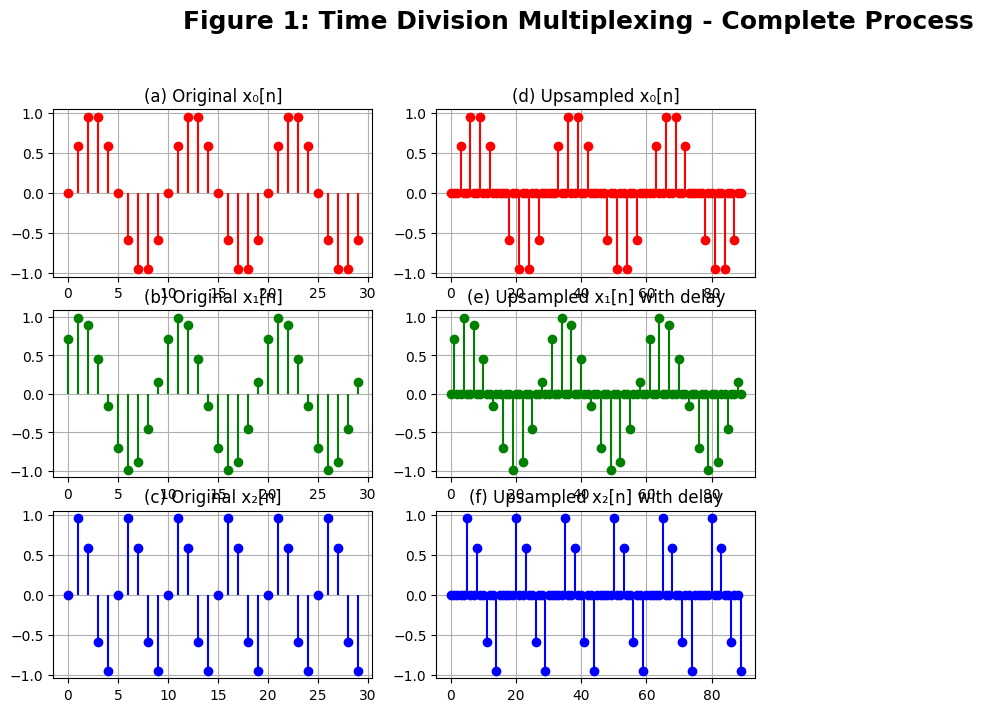

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 30
n = np.arange(N)

# Generate signals
x0 = np.sin(2*np.pi*0.1*n)
x1 = np.sin(2*np.pi*0.1*n + np.pi/4)
x2 = np.sin(2*np.pi*0.2*n)

# Upsample by factor 3
def upsample(x, L):
    y = np.zeros(len(x)*L)
    y[::L] = x
    return y

x0_u = upsample(x0, 3)
x1_u = upsample(x1, 3)
x2_u = upsample(x2, 3)

# Apply delays
x1_d = np.concatenate(([0], x1_u[:-1]))       # z^-1
x2_d = np.concatenate(([0, 0], x2_u[:-2]))    # z^-2

# TDM signal
y = x0_u + x1_d + x2_d

# Demultiplexing
x0_rec = y[0::3]
x1_rec = y[1::3]
x2_rec = y[2::3]

# Visualization
fs = 14
lw = 2
markerSize = 8

# Figure 1
plt.figure(figsize=(14, 10))
plt.suptitle("Figure 1: Time Division Multiplexing - Complete Process", fontsize=fs+4, fontweight="bold")

# Column 1: Original signals
plt.subplot(4,3,1)
plt.stem(n, x0, basefmt=" ", linefmt='r', markerfmt='ro')
plt.title("(a) Original x₀[n]")
plt.grid(True)

plt.subplot(4,3,4)
plt.stem(n, x1, basefmt=" ", linefmt='g', markerfmt='go')
plt.title("(b) Original x₁[n]")
plt.grid(True)

plt.subplot(4,3,7)
plt.stem(n, x2, basefmt=" ", linefmt='b', markerfmt='bo')
plt.title("(c) Original x₂[n]")
plt.grid(True)

# Column 2: Upsampled + delayed
n_up = np.arange(len(x0_u))

plt.subplot(4,3,2)
plt.stem(n_up, x0_u, basefmt=" ", linefmt='r', markerfmt='ro')
plt.title("(d) Upsampled x₀[n]")
plt.grid(True)

plt.subplot(4,3,5)
plt.stem(n_up, x1_d, basefmt=" ", linefmt='g', markerfmt='go')
plt.title("(e) Upsampled x₁[n] with delay")
plt.grid(True)

plt.subplot(4,3,8)
plt.stem(n_up, x2_d, basefmt=" ", linefmt='b', markerfmt='bo')
plt.title("(f) Upsampled x₂[n] with delay")
plt.grid(True)

# Column 3: TDM signal (spanning rows)
plt.subplot(4,3,(3,6,9,12))
plt.stem(n_up, y, basefmt=" ", linefmt='m', markerfmt='mo')
plt.title("(g) TDM Output y[n]")
plt.grid(True)

# Figure 2: Recovery
plt.figure(figsize=(12, 8))
plt.suptitle("Figure 2: Signal Recovery After Demultiplexing", fontsize=fs+4, fontweight="bold")

plt.subplot(3,2,1)
plt.stem(n, x0, basefmt=" ", linefmt='r', markerfmt='ro')
plt.title("(a) Original x₀[n]")
plt.grid(True)

plt.subplot(3,2,2)
plt.stem(np.arange(len(x0_rec)), x0_rec, basefmt=" ", linefmt='r', markerfmt='ro')
plt.title("(b) Recovered x₀[n]")
plt.grid(True)

plt.subplot(3,2,3)
plt.stem(n, x1, basefmt=" ", linefmt='g', markerfmt='go')
plt.title("(c) Original x₁[n]")
plt.grid(True)

plt.subplot(3,2,4)
plt.stem(np.arange(len(x1_rec)), x1_rec, basefmt=" ", linefmt='g', markerfmt='go')
plt.title("(d) Recovered x₁[n]")
plt.grid(True)

plt.subplot(3,2,5)
plt.stem(n, x2, basefmt=" ", linefmt='b', markerfmt='bo')
plt.title("(e) Original x₂[n]")
plt.grid(True)

plt.subplot(3,2,6)
plt.stem(np.arange(len(x2_rec)), x2_rec, basefmt=" ", linefmt='b', markerfmt='bo')
plt.title("(f) Recovered x₂[n]")
plt.grid(True)

plt.tight_layout()
plt.show()

# MSE
mse_x0 = np.mean((x0[:len(x0_rec)] - x0_rec)**2)
mse_x1 = np.mean((x1[:len(x1_rec)] - x1_rec)**2)
mse_x2 = np.mean((x2[:len(x2_rec)] - x2_rec)**2)

print("Mean Squared Error:")
print(f"• x₀ MSE: {mse_x0:.2e}")
print(f"• x₁ MSE: {mse_x1:.2e}")
print(f"• x₂ MSE: {mse_x2:.2e}")


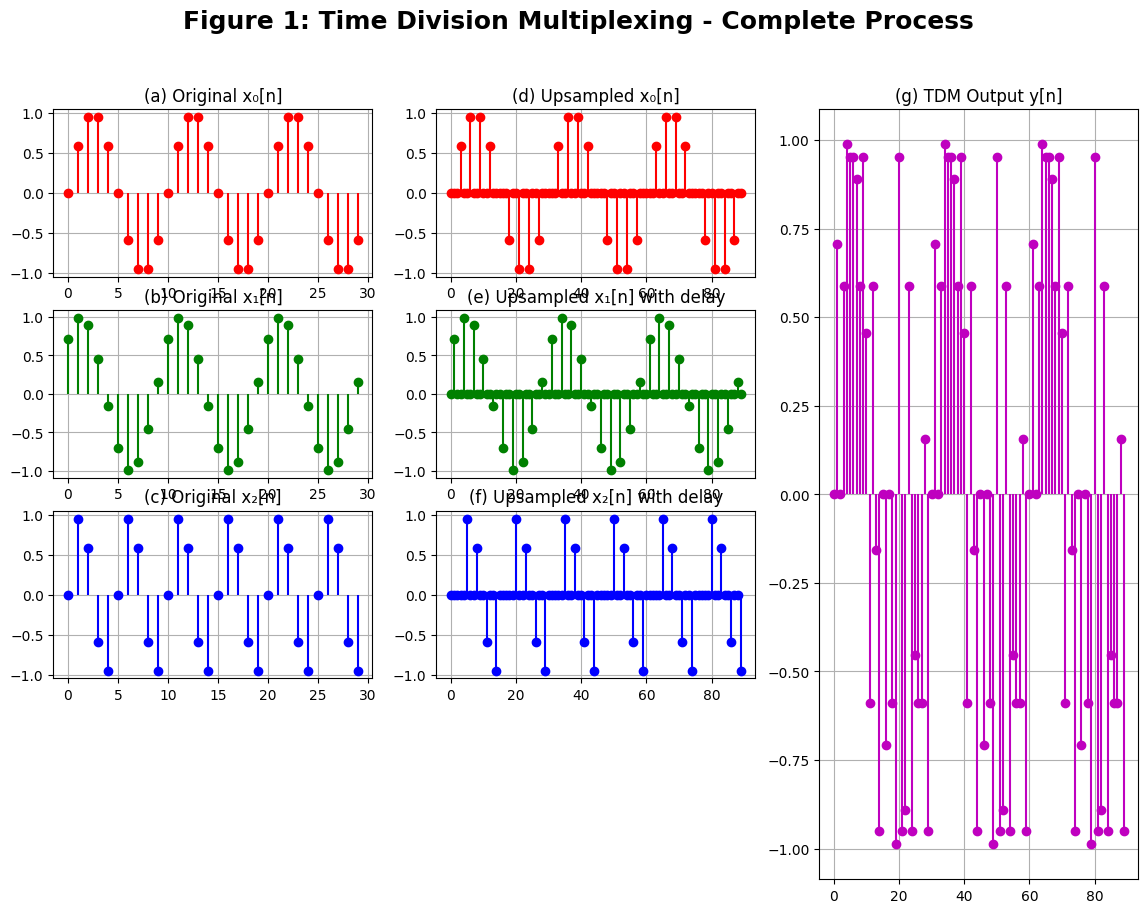

In [2]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(14, 10))
plt.suptitle("Figure 1: Time Division Multiplexing - Complete Process", fontsize=fs+4, fontweight="bold")

gs = gridspec.GridSpec(4, 3)

# ----- Left column: original -----
plt.subplot(gs[0, 0])
plt.stem(n, x0, basefmt=" ", linefmt='r', markerfmt='ro')
plt.title("(a) Original x₀[n]")
plt.grid(True)

plt.subplot(gs[1, 0])
plt.stem(n, x1, basefmt=" ", linefmt='g', markerfmt='go')
plt.title("(b) Original x₁[n]")
plt.grid(True)

plt.subplot(gs[2, 0])
plt.stem(n, x2, basefmt=" ", linefmt='b', markerfmt='bo')
plt.title("(c) Original x₂[n]")
plt.grid(True)

# ----- Middle column: upsampled + delayed -----
plt.subplot(gs[0, 1])
plt.stem(n_up, x0_u, basefmt=" ", linefmt='r', markerfmt='ro')
plt.title("(d) Upsampled x₀[n]")
plt.grid(True)

plt.subplot(gs[1, 1])
plt.stem(n_up, x1_d, basefmt=" ", linefmt='g', markerfmt='go')
plt.title("(e) Upsampled x₁[n] with delay")
plt.grid(True)

plt.subplot(gs[2, 1])
plt.stem(n_up, x2_d, basefmt=" ", linefmt='b', markerfmt='bo')
plt.title("(f) Upsampled x₂[n] with delay")
plt.grid(True)

# ----- Right column: big subplot -----
ax = plt.subplot(gs[:, 2])   # span all rows
ax.stem(n_up, y, basefmt=" ", linefmt='m', markerfmt='mo')
ax.set_title("(g) TDM Output y[n]")
ax.grid(True)

